In [5]:
import matplotlib.pyplot as plt
from ANN_models import PredictionModel, PredictionModel2
import os 
import json
import torch
import numpy as np

In [6]:
result_folder = "prediction_model2"

In [7]:
os.makedirs(os.path.join("pic", result_folder), exist_ok=True)
with open(os.path.join("OPs_used", "SO2.json"), 'r') as f:
    SO2 = json.load(f)
    test_SO2 = SO2['test_SO2']
with open(os.path.join("model_save", result_folder, 'trlog.json'), 'r') as f:
    config = json.load(f)
test_loader = torch.load(os.path.join("model_save", result_folder, 'test_loader.pth'))
model = PredictionModel2().cuda()
model.load_state_dict(torch.load(config['best_model']))
model.eval()

PredictionModel2(
  (net): Sequential(
    (0): Linear(in_features=80, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)

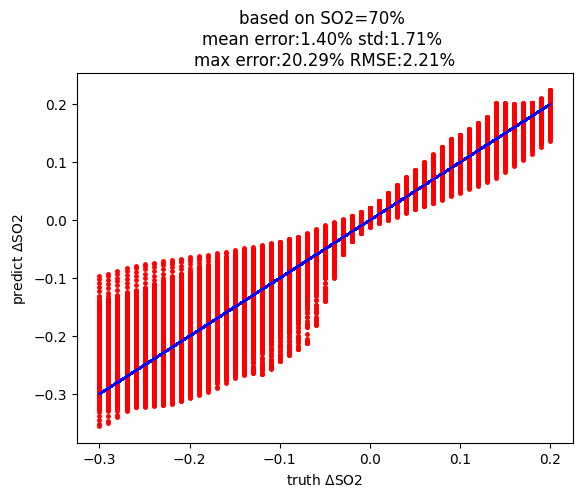

In [8]:
for batch_idx, (data,target, parameters) in enumerate(test_loader):
    data,target = data.to(torch.float32).cuda(), target.to(torch.float32).cuda()
    output = model(data)
    output = output.detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    if batch_idx == 0:
        error = 100*(output - target)
        RMSE = 100*(output - target)
    else:
        error = np.concatenate((error, 100*(output - target)))
        RMSE = np.concatenate((RMSE, 100*(output - target)))
    plt.plot(target,output, 'r.', markersize=5)
    plt.plot(target,target,'b')

RMSE = np.sqrt(np.mean(np.square(RMSE)))
mean = np.mean(np.abs(error))
std = np.std(np.abs(error))
max_error = np.max(np.abs(error))
plt.title(f"based on SO2=70% \nmean error:{mean:.2f}% std:{std:.2f}% \nmax error:{max_error:.2f}% RMSE:{RMSE:.2f}%")
plt.xlabel("truth $\u0394$SO2")
plt.ylabel("predict $\u0394$SO2")
plt.savefig(os.path.join("pic", result_folder, "RMSE.png"), dpi=300, format='png', bbox_inches='tight')
plt.show()

In [18]:
max(n)

28736.0

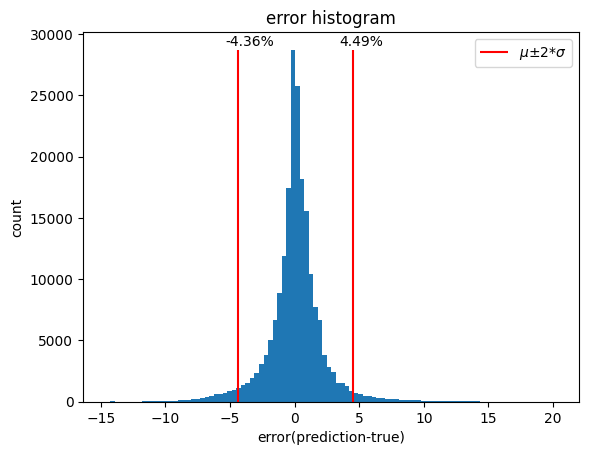

In [37]:
mean = np.mean(error)
std = np.std(error)
n,bin, pack = plt.hist(error, bins=100)
plt.vlines([mean+2*std, mean-2*std], 0, max(n), 'r', label='$\mu$$\pm$2*$\sigma$')
plt.text(mean+2*std-1, max(n)+300, f'{mean+2*std:.2f}%')
plt.text(mean-2*std-1, max(n)+300, f'{mean-2*std:.2f}%')
plt.xlabel('error(prediction-true)')
plt.ylabel('count')
plt.title('error histogram')
plt.savefig(os.path.join("pic", result_folder, "hist.png"), dpi=300, format='png', bbox_inches='tight')
plt.legend()